In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option("display.max_columns", 999)

# Import Analysis Data

In [120]:
%%time
df = pd.read_csv("./input/dataReady.csv", index_col=0)
LabelMap = np.load('./input/LabelMapping.npy').item()

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 16.4 s, sys: 1.1 s, total: 17.6 s
Wall time: 17.6 s


# Exploratory Data Visualization
Exploratory data visualization based on [Seaborn](http://seaborn.pydata.org/index.html) library.

For the visualizations, I calcuate short trip percentages at first. Then I make barplot or scatterplot to see if some variable has a pattern on short trip percentage.

Below is a histogram on trip distance in km. Some trips can be as long as over 12 km. Note that there are also many trips having distance 0, which means people rent and return their bike from/to the same station.

In [121]:
df['distance'].max()

31.3176257339633

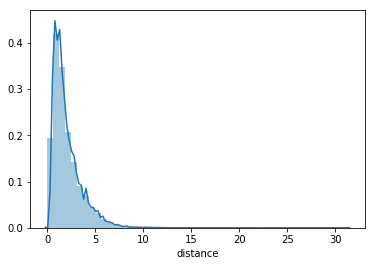

In [122]:
sns.distplot(df['distance'], rug=False)

In [123]:
df['short_trip'] = df['distance'].apply(lambda x: "< 2km" if x < 2.0 else ">= 2km")

In [124]:
pd.concat([df['short_trip'].value_counts(), df['short_trip'].value_counts() / df.shape[0]], axis=1)

,short_trip,short_trip
< 2km,2319992,0.630932
>= 2km,1357096,0.369068


Among all the trips, "short_trip" is defined as trip distance less than 2 km. Below is a table for short trip histogram.

| Trip Type | Percentage |  Count    |
|:---------:|:----------:| ---------:|
| < 2km     | 63.1%      | 2,319,992 |
| >= 2km    | 36.9%      | 1,357,096 |

In [125]:
def create_st_pct(byname):
    """
    function to create df for plotting byname with corresponding short trip percentage
    
    """
    df0 = df.groupby(byname).agg({'short_trip':[ lambda x: sum(x == '< 2km')/x.shape[0]]})
    df0.columns = ['short_trip_pct']
    df0 = df0.sort_values('short_trip_pct', ascending=False)
    df0[byname] = df0.index
    df0.index = range(df0.shape[0])
    
    return df0

def plot_st_pct(byname, hori=True):
    df0 = create_st_pct(byname)
    
    if hori == True:
        sns.barplot(y=byname, x="short_trip_pct", data=df0, color="cornflowerblue")
    else:
        sns.barplot(x=byname, y="short_trip_pct", data=df0)

### Short trip percentage on all stations

It suggests that origin station is an important feature for predicting short trip.

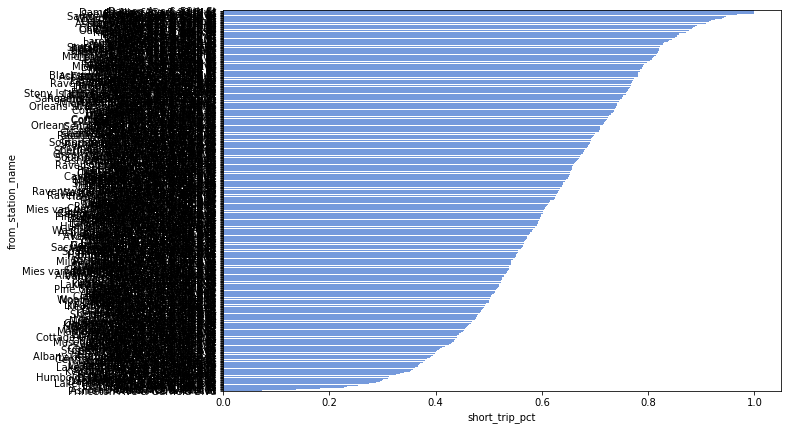

In [126]:
plt.figure(figsize=(10,7))
plot_st_pct('from_station_name')

### Top/bottom 10 short trip percentage stations

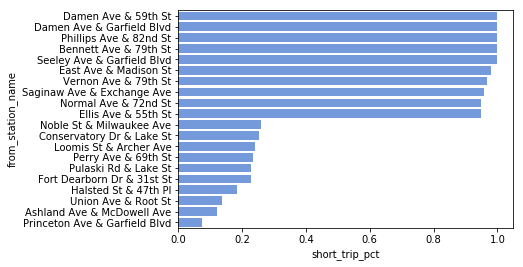

In [127]:
station_st_pct = create_st_pct('from_station_name')
sns.barplot(y="from_station_name", x="short_trip_pct", data=pd.concat([station_st_pct[:10], station_st_pct[-10:]], axis=0), color="cornflowerblue")

### Usertype

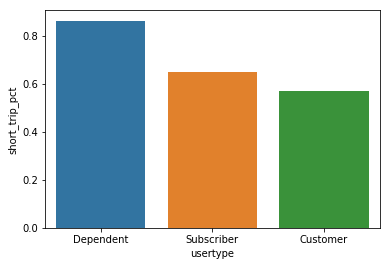

In [128]:
plot_st_pct('usertype', hori=False)

### Gender

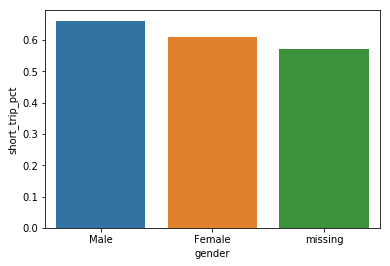

In [129]:
plot_st_pct('gender', hori=False)

### Trip starting year

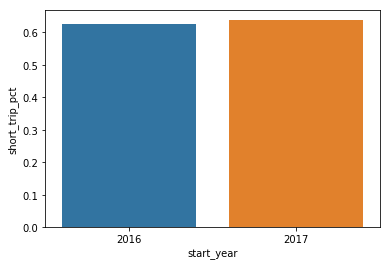

In [130]:
plot_st_pct('start_year', hori=False)

### Trip starting month
It's clear that winter will have more short trips and summer will have fewer short trips.

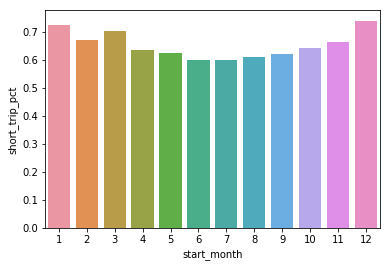

In [131]:
plot_st_pct('start_month', hori=False)

### Trip starting hour

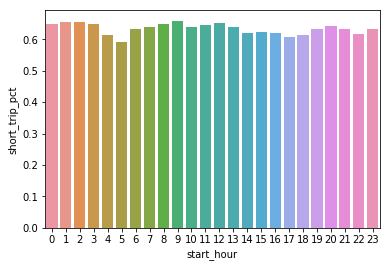

In [132]:
plot_st_pct('start_hour', hori=False)

### Trip starting weekday/weekend

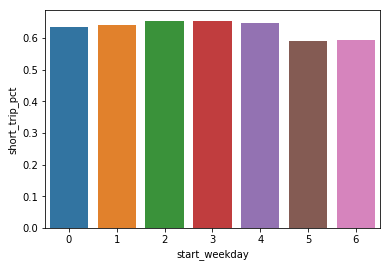

In [133]:
#{'start_weekday':{0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',
#                  4:'Friday', 5:'Saturday', 6:'Sunday'}}
weekday_st_pct = create_st_pct('start_weekday')
sns.barplot(x='start_weekday', y='short_trip_pct', data=weekday_st_pct)

### Hourly Cloud Cover 

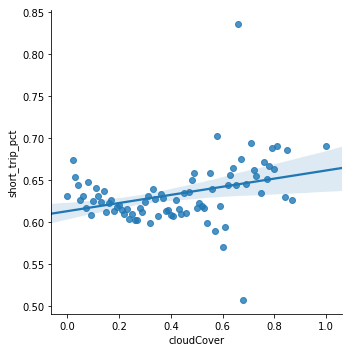

In [134]:
df_cloud = create_st_pct('cloudCover')
sns.lmplot(x='cloudCover', y='short_trip_pct', data=df_cloud)

### Daily Cloud Cover 

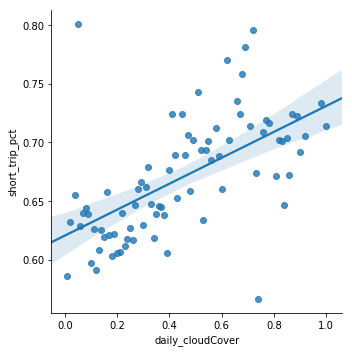

In [135]:
df_cloud_daily = create_st_pct('daily_cloudCover')
sns.lmplot(x='daily_cloudCover', y='short_trip_pct', data=df_cloud_daily)

### Hourly Apparent Temerature

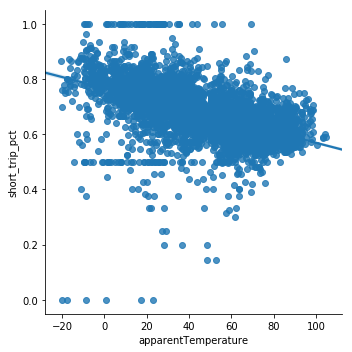

In [136]:
sns.lmplot(x='apparentTemperature', y='short_trip_pct', data=create_st_pct('apparentTemperature'))

### Hourly Temperature

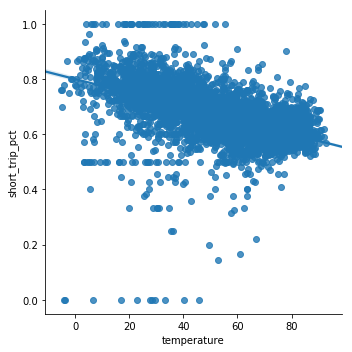

In [137]:
sns.lmplot(x='temperature', y='short_trip_pct', data=create_st_pct('temperature'))

### Daily Apparent Temerature High

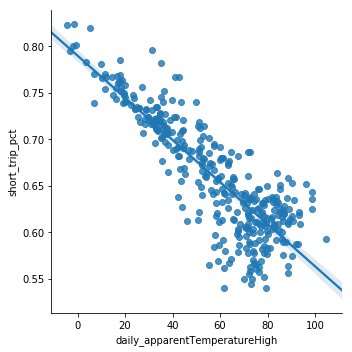

In [138]:
sns.lmplot(x='daily_apparentTemperatureHigh', y='short_trip_pct', data=create_st_pct('daily_apparentTemperatureHigh'))

### Daily Apparent Temerature Low

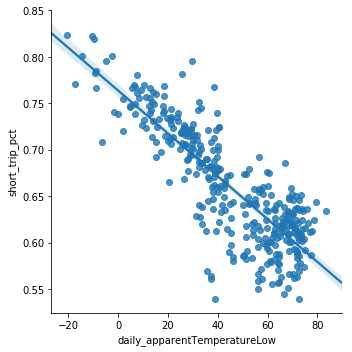

In [139]:
sns.lmplot(x='daily_apparentTemperatureLow', y='short_trip_pct', data=create_st_pct('daily_apparentTemperatureLow'))

### Hourly Humidity

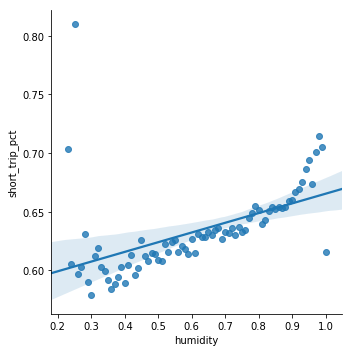

In [140]:
sns.lmplot(x='humidity', y='short_trip_pct', data=create_st_pct('humidity'))

### Daily Humidity

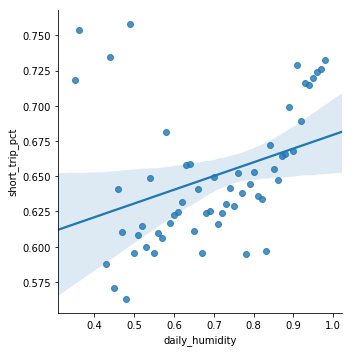

In [141]:
sns.lmplot(x='daily_humidity', y='short_trip_pct', data=create_st_pct('daily_humidity'))

### Birthyear

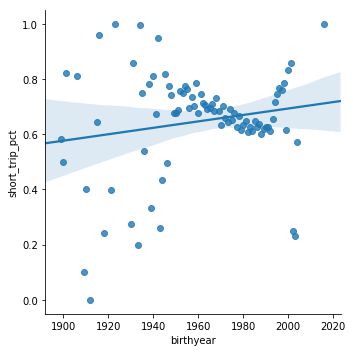

In [142]:
sns.lmplot(x='birthyear', y='short_trip_pct', data=create_st_pct('birthyear'))

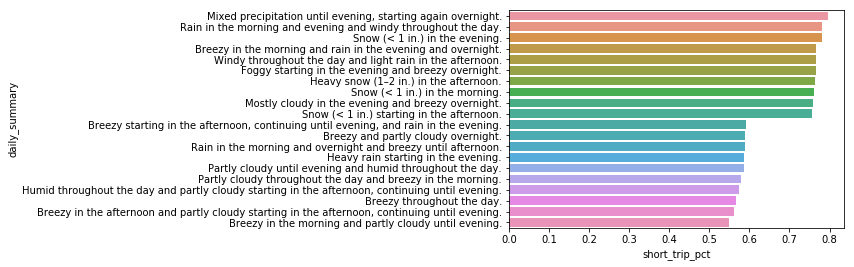

In [145]:
df_dailySum = create_st_pct('daily_summary')
sns.barplot(y='daily_summary', x='short_trip_pct', data=pd.concat([df_dailySum[:10],df_dailySum[-10:]], axis=0))

### Hourly Wind Speed

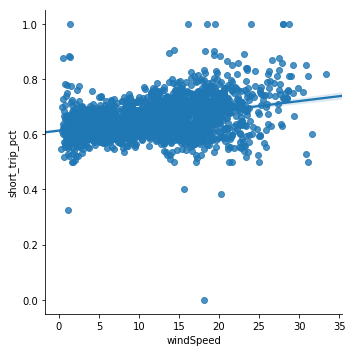

In [147]:
sns.lmplot(x='windSpeed', y='short_trip_pct', data=create_st_pct('windSpeed'))

### Hourly Wind Bearing

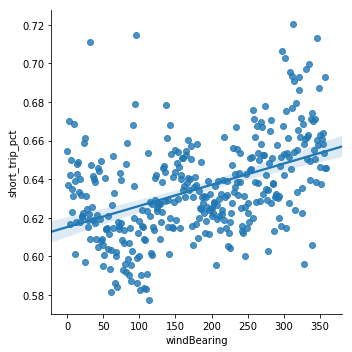

In [148]:
sns.lmplot(x='windBearing', y='short_trip_pct', data=create_st_pct('windBearing'))

### Hourly Pressure

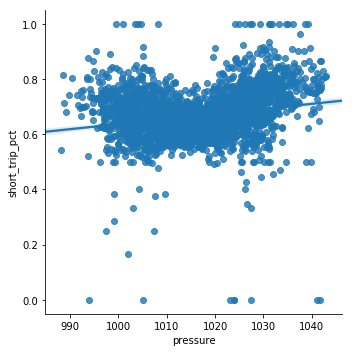

In [149]:
sns.lmplot(x='pressure', y='short_trip_pct', data=create_st_pct('pressure'))

### Hourly Dewpoint

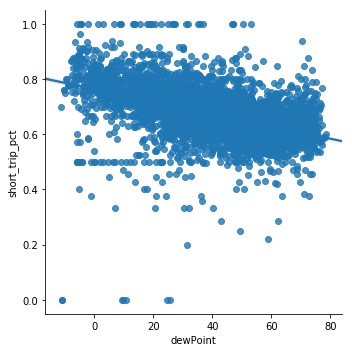

In [150]:
sns.lmplot(x='dewPoint', y='short_trip_pct', data=create_st_pct('dewPoint'))

### Hourly Visibility

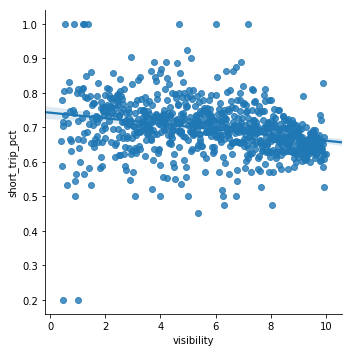

In [151]:
sns.lmplot(x='visibility', y='short_trip_pct', data=create_st_pct('visibility'))

## Train Validation Test Split

I use 75%/25% as the training/testing set split, stratified by start_month.

| Dataset | Percentage | Number of Observations |
|:-------:|:----------:| ---------:|
| Train   | 75%        | 2,757,816 |
| Test    | 25%        |   919,272 |

In [152]:
%%time
df = pd.read_csv("./input/dataReady.csv", index_col=0)
LabelMap = np.load('./input/LabelMapping.npy').item()

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 17.1 s, sys: 996 ms, total: 18.1 s
Wall time: 18.1 s


In [153]:
%time df.replace(LabelMap, inplace=True)

CPU times: user 1min 15s, sys: 116 ms, total: 1min 15s
Wall time: 1min 15s


In [154]:
# used for LightGBM categorical feature
categorical_colName = ['from_station_name', 'usertype', 'gender', 'start_year', 'daily_icon', 'daily_precipType', 'daily_summary', 'icon', 'precipType', 'summary']

In [155]:
from sklearn.model_selection import train_test_split

In [156]:
%%time
train, test = train_test_split(df, test_size=.25, train_size=.75, stratify=df['start_month'].tolist(), random_state=0)
print(train.shape, test.shape)

(2757816, 61) (919272, 61)
CPU times: user 4.02 s, sys: 1.24 s, total: 5.26 s
Wall time: 5.26 s


# Load LightGBM and Xgboost Models

In [157]:
# create input data
def generate_model_input(df):
    '''return format: X_train, y_train'''
    keep_col = df.columns.tolist()
    keep_col.remove('distance')
    
    return df[keep_col], (df['distance'] < 2.0).tolist()

X_train, y_train = generate_model_input(train)
X_test, y_test = generate_model_input(test)

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# create dataset for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain,'train'), (dtest,'eval')]

In [158]:
# load lightgbm model
gbm = lgb.Booster(model_file="lgb_model_1.txt")

# load xgboost model
bst = xgb.Booster(model_file="xgb_model")

In [159]:
# lightgbm prediction
%time y_pred_gbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)

CPU times: user 26min 48s, sys: 671 ms, total: 26min 48s
Wall time: 3min 29s


In [160]:
# xgboost prediction
%time y_pred_bst = bst.predict(xgb.DMatrix(X_test))

CPU times: user 7min 56s, sys: 446 ms, total: 7min 56s
Wall time: 1min 1s


## Feature Importance

In [161]:
df_fetrImpt = pd.DataFrame.from_dict(bst.get_fscore(), orient='index')
df_fetrImpt = df_fetrImpt.rename(columns={0:'Xgboost'})
df_fetrImpt['feature'] = df_fetrImpt.index.tolist()
df_fetrImpt.index = range(df_fetrImpt.shape[0])
df_fetrImpt = df_fetrImpt.merge(pd.DataFrame({'feature':gbm.feature_name(), 'LightGBM':gbm.feature_importance()}), on='feature')
df_fetrImpt['Xgboost'] = df_fetrImpt['Xgboost'] / df_fetrImpt['Xgboost'].sum()
df_fetrImpt['LightGBM'] = df_fetrImpt['LightGBM'] / df_fetrImpt['LightGBM'].sum()

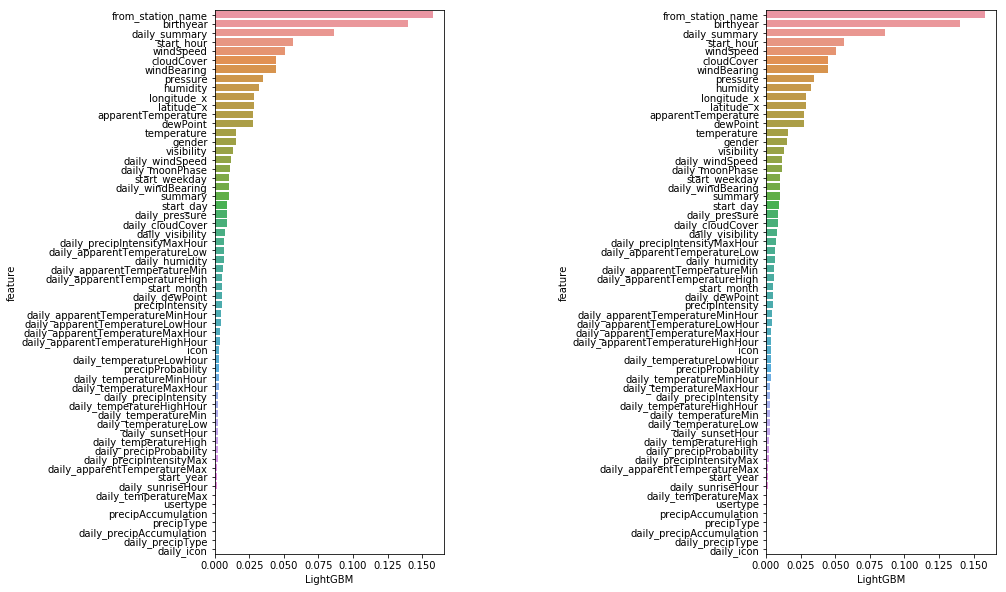

In [162]:
plt.figure(figsize=(14,10))
plt.subplot(1, 3, 1)
sns.barplot(y='feature', x='LightGBM', data=df_fetrImpt.sort_values(by='LightGBM', ascending=False), orient='h')
plt.subplot(1, 3, 3)
sns.barplot(y='feature', x='LightGBM', data=df_fetrImpt.sort_values(by='LightGBM', ascending=False), orient='h')

## ROC Curve and AUC

In [163]:
from sklearn.metrics import roc_curve, auc

In [164]:
# Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr["LightGBM"], tpr["LightGBM"], _ = roc_curve(y_test, y_pred_gbm)
fpr["Xgboost"], tpr["Xgboost"], _ = roc_curve(y_test, y_pred_bst)
roc_auc["LightGBM"] = auc(fpr["LightGBM"], tpr["LightGBM"])
roc_auc["Xgboost"] = auc(fpr["Xgboost"], tpr["Xgboost"])

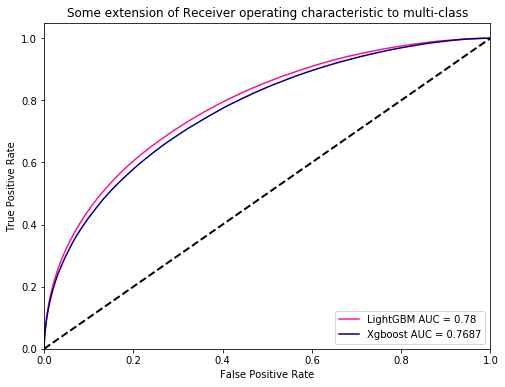

In [192]:
plt.figure(figsize=(8, 6))
plt.plot(fpr["LightGBM"], tpr["LightGBM"],
         label='LightGBM AUC = {0:0.2f}'
               ''.format(roc_auc["LightGBM"]),
         color='deeppink')

plt.plot(fpr["Xgboost"], tpr["Xgboost"],
         label='Xgboost AUC = {0:0.4f}'
               ''.format(roc_auc["Xgboost"]),
         color='navy')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

LightGBM is slightly better than Xgboost in AUC.

## Confusion Matrix

In [166]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [167]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The graphs below are confusion matrices for two methods. LightGBM is better in predicting true negatives. Xgboost is better in predicting true positives.

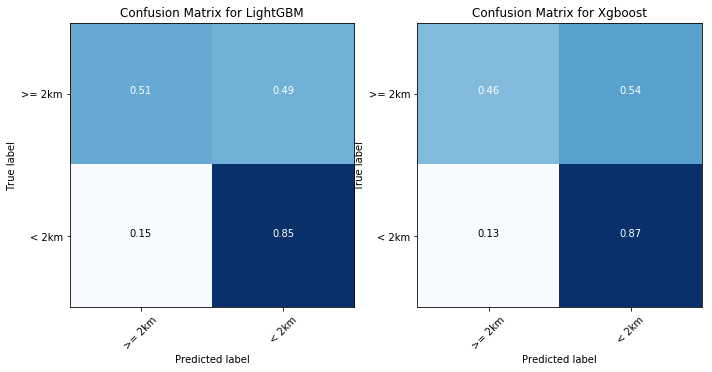

In [168]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plot_confusion_matrix(y_test, y_pred_gbm > .5, ['>= 2km', '< 2km'], title="Confusion Matrix for LightGBM")
plt.subplot(1, 2, 2)
plot_confusion_matrix(y_test, y_pred_bst > .5, ['>= 2km', '< 2km'], title="Confusion Matrix for Xgboost")

# Ensemble Model

Use a linear combination of LightGBM and Xgboost as an ensemble model.

In [179]:
%%time
esb_fpr = dict()
esb_tpr = dict()
esb_auc = dict()
for w in np.linspace(.01, .99, 99):
    print(w)
    y_pred_esb = [w * x + (1 - w) * y for x, y in zip(y_pred_gbm, y_pred_bst)]
    fpr[w], tpr[w], _ = roc_curve(y_test, y_pred_esb)
    esb_auc[w] = auc(fpr[w], tpr[w])

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
CPU times: user 1min 4s, sys: 88 ms, total: 1min 4s
Wall time: 1min 4s


In [196]:
wmax = max(esb_auc.keys(), key=(lambda k: esb_auc[k]))

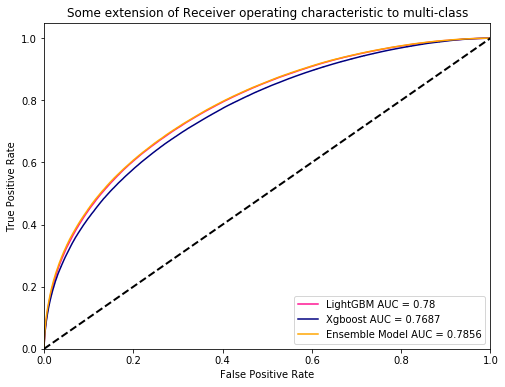

In [201]:
plt.figure(figsize=(8, 6))
plt.plot(fpr["LightGBM"], tpr["LightGBM"],
         label='LightGBM AUC = {0:0.2f}'
               ''.format(roc_auc["LightGBM"]),
         color='deeppink')

plt.plot(fpr["Xgboost"], tpr["Xgboost"],
         label='Xgboost AUC = {0:0.4f}'
               ''.format(roc_auc["Xgboost"]),
         color='navy')

plt.plot(fpr[wmax],
         tpr[wmax],
         label='Ensemble Model AUC = {0:0.4f}'
               ''.format(esb_auc[wmax]),
         color='orange')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

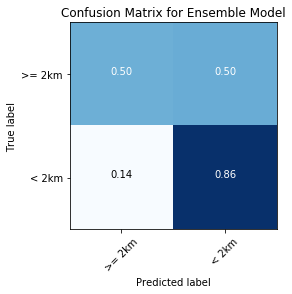

In [217]:
y_pred_esb = np.array([wmax * x + (1 - wmax) * y for x, y in zip(y_pred_gbm, y_pred_bst)])
plot_confusion_matrix(y_test, y_pred_esb > .5,
                      ['>= 2km', '< 2km'],
                      title="Confusion Matrix for Ensemble Model")

Ensemble model slightly improves both models.

If the trip is truly less than 2 km, our model can reach 86% accuracy. If the trip is truly longer than 2 km, our model did really badly. It's as bad as random guess with 50%/50% chances.

## Overall Accuracy

| Method   | Accuracy |
|:--------:|---------:|
| LightGBM | 0.7266   |
| Xgboost  | 0.7158   |
| Ensemble | 0.7275   |

In [210]:
np.mean((y_pred_gbm > .5) == y_test)

0.7266478256707481

In [212]:
np.mean((y_pred_bst > .5) == y_test)

0.7157565986998408

In [218]:
np.mean((y_pred_esb > .5) == y_test)

0.727507201350634